Note: this notebook has a method of calculating distances between ECTs by using `np.roll` at the beginning, but at the end it has another method by using orientation by PCA. Documentation could be better, this is just to explore.

# Import modules

In [1]:
#-----------------
# Standard imports
#-----------------
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
from sklearn.decomposition import PCA # for PCA for normalization
from scipy.spatial import distance_matrix

from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.manifold import MDS # for MDS
import pandas as pd # for loading in colors csv
from scipy.spatial import ConvexHull # for convex hull
import seaborn as sns # for plotting

#---------------------------
# The ECT packages we'll use
#---------------------------
from ect import ECT, EmbeddedGraph # for calculating ECTs

# Define functions

In [2]:
def normalize(shape):
    """
    input: ordered coordinates of a 2D closed contour
    output: 2D array, coordinates origin centered on centroid and longest radius = 1
    """
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of leaf

    # return leaf normalized by longest axis to 1, zero centered
    return pca_scores/(np.max(pca_scores[:,0])-np.min(pca_scores[:,0]))

In [3]:
def get_ect(normal_sh, dir_num, thresh_num, global_bound_radius):
    """
    inputs: ordered coordinates of a normalized 2D closed contour, longest diameter = 1
    dir_num = number of directional axes
    thresh_num = number of thresholds
    global_bound_radius = half of the longest normalized diameter
    output: ECT as 2D array
    """
    G = EmbeddedGraph() # initiate an embedded graph

    valuesX = normal_sh[:,0] # isolate x vals
    valuesY = normal_sh[:,1] # isolate y vals
    for i in range(np.shape(normal_sh)[0]): # create nodes
        G.add_node(i,valuesX[i],valuesY[i])
    for i in range(np.shape(normal_sh)[0]-1): # create edges
        G.add_edge(i, i+1)
    G.add_edge(0,np.shape(normal_sh)[0]-1) # add final edge between start and end

    myect = ECT(num_dirs = dir_num, num_thresh=thresh_num) # intiate ECT
    myect.set_bounding_radius(global_bound_radius) # set bounding radius
    myect.calculateECT(G) # calculate ECT on embedded graph

    return myect.get_ECT() # retrieve ECT, 2D array, [axes, thresh]

In [4]:
def ect_diff(ect1, ect2,dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    diffs = [] # store differences 
    for i in range(dir_num): # for the number of directional axes
        roll_ect = np.roll(ect1,i,axis=0) # roll the array by 1 along directional axes
        diff_ect = np.abs(ect2 - roll_ect) # difference between the two arrays
        diffs.append(np.sum(diff_ect)) # store the sum of the differences
    return np.min(diffs) # return minimum difference

In [5]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# Define datasets and groups

In [6]:
# a list of folder directories of datasets to analyze
datasets = ["Alstroemeria",
            "Apple",
            "Arabidopsis",
            "Arabidopsis_asymmetry",
            "Brassica/napus",
            "Brassica/rapa",
            "Coleus/Co1",
            "Coleus/Co2",
            "Coleus/Co3",
            "Coleus/Co4",
            "Coleus/Co5",
            "Coleus/Co6",
            "Cotton",
            "Grape/Domesticated_grape/GrapeJune1.2011",
            "Grape/Domesticated_grape/GrapeMay28.2011",
            "Grape/Domesticated_grape/GrapeMay29.2011",
            "Grape/Domesticated_grape/GrapeMay30.2011",
            "Grape/Domesticated_grape/GrapeMay31.2011",
            "Grape/Geneva_2013/Folder1_Jose",
            "Grape/Geneva_2013/Folder2_Tommy",
            "Grape/Geneva_2013/Folder3_Danny",
            "Grape/Geneva_2013/Folder4_Quaneisha",
            "Grape/Geneva_2013/Folder5_Susan",
            "Grape/Geneva_2013/Folder6_Darren",
            "Grape/Geneva_2013/Folder7_Jose2",
            "Grape/Geneva_2013/Folder8_Susan2",
            "Grape/Geneva_2013/Folder9_Tommy2",
            "Grape/Geneva_2013/Folder10_Quaneisha2",
            "Grape/Geneva_2013/Folder11_Darren2",
            "Grape/Geneva_2013/Folder12_Danny",
            "Grape/Geneva_2015/060815",
            "Grape/Geneva_2015/060915",
            "Grape/Geneva_2015/061015",
            "Grape/Geneva_2016/Dan_Geneva_2016",
            "Grape/Geneva_2016/MF_Geneva_2016",
            "Grape/MtVernon_scans/2014_MtVernon_Scans",
            "Grape/MtVernon_scans/2016_MtVernon_Scans",
            "Grass",
            "Ivy",
            "Leafsnap",
            "Passiflora",
            "Pepper",
            "Transect/Batch_1_W",
            "Transect/Batch_2_B",
            "Viburnum/V1",
            "Viburnum/V2",
           ]

# make a list of overall groups
groups = [] # store group names

for i in datasets: # for each dataset
    if "/" in i: # if there are subfolders
        groups.append(i[:i.index('/')]) # then only take the name of the first folder
    elif "_" in i: # if there is a redundant folder with "_" like Arabidopsis
        groups.append(i[:i.index('_')]) # then only take the name of the first folder
    else:
        groups.append(i) # otherwise just take the whole name

# Create a downsampled dataset

Create a pandas dataframe of file names, groups, and datasets

In [7]:
file_names = [] # store file names
dataset = [] # store dataset names
group = [] # store group names

for i in range(len(datasets)): # for each dataset
    
    curr_dataset = datasets[i] # get current dataset
    curr_group = groups[i] # get current group
    data_dir = "./2017_leaves/"+curr_dataset+"/" # set data directory
    files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
    #file_names.remove('.DS_Store') # remove .DS_Store file
    files.sort() # sort the list of file names

    for j in range(len(files)): # for each file
        
        file_names.append("./2017_leaves/"+curr_dataset+"/"+files[j]) # store file names
        dataset.append(curr_dataset) # store datasets
        group.append(curr_group) # store group
        
# create a pandas dataframe of all file info
lf_df = pd.DataFrame(
    {"group":group,
     "dataset":dataset,
     "file":file_names,
    })

# print out number of each dataset
lf_df["group"].value_counts()

group
Coleus          34607
Grape           11379
Apple            9619
Transect         5808
Arabidopsis      5101
Leafsnap         4565
Passiflora       3298
Pepper           3277
Cotton           2885
Viburnum         2422
Alstroemeria     2392
Brassica         1832
Grass             866
Ivy               865
Name: count, dtype: int64

# Select a random number of leaves from each group

In [8]:
rand_num = 50 # select number to randomly sample
df_list = [] # a list to store pandas dataframes
rand_state = 42 # set the random state

for i in lf_df["group"].unique(): # for each group
    curr_group = lf_df[lf_df["group"]==i] # select all samples of current group
    df_list.append(curr_group.sample(n=rand_num, random_state=rand_state)) # select random rows for the current group
    
rand_df = pd.concat(df_list).reset_index() # concatenate list of dataframes together

print(len(rand_df)) # print the overall length of the selected leaves

700


# Analyze solidity and aspect ratio

Calculate solidity and aspect ratio

In [9]:
solidity = [] # store solidity values
wl_ratio = [] # store width-to-length ratio values

for i in range(len(rand_df)): # for each of the randomly selected leaves
    
    curr_file = rand_df["file"].iloc[i] # get current file
     
    # calculate solidity
    curr_lf = np.load(curr_file) # load current leaf
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    area = poly_area(curr_lf[:,0], curr_lf[:,1]) # calculate area
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity.append( area / convex_area ) # calculate solidity and store

    # calculate length-to-width ratio
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
    length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
    width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
    wl_ratio.append(width/length) # store length-to-width ratio
    
rand_df["solidity8"] = np.array(solidity)**8 # add solidity to random leaves
rand_df["wl_ratio"] = wl_ratio # add width-to-length ratio to random leaves

Plot solidity and aspect ratio

Text(0.5, 1.0, 'Solidity^8 vs width-to-length ratio\nby group')

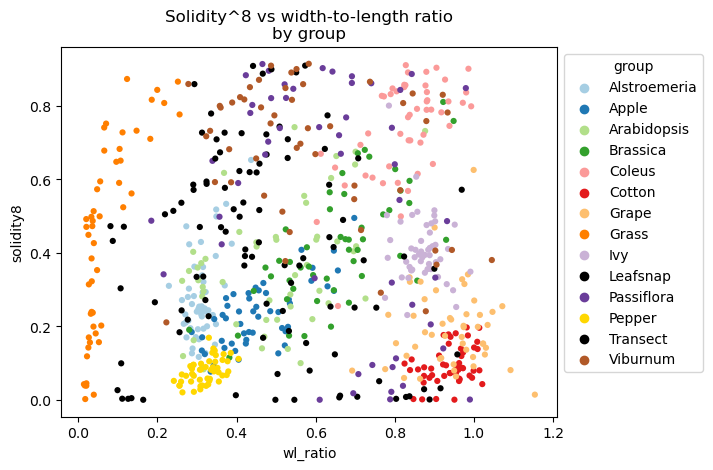

In [10]:
palette = [
"#a6cee3",
"#1f78b4",
"#b2df8a",
"#33a02c",
"#fb9a99",
"#e31a1c",
"#fdbf6f",
"#ff7f00",
"#cab2d6",
"black",
"#6a3d9a",
"gold",
"black",
"#b15928"
]


ax = sns.scatterplot(data=rand_df,
                x="wl_ratio",
                y="solidity8",
                hue="group",
                palette=sns.color_palette(palette, 14),
                s=20,
                linewidth=0,
                alpha=1
               )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Solidity^8 vs width-to-length ratio\nby group")

Plot solidity and aspect ratio with leaf outlines

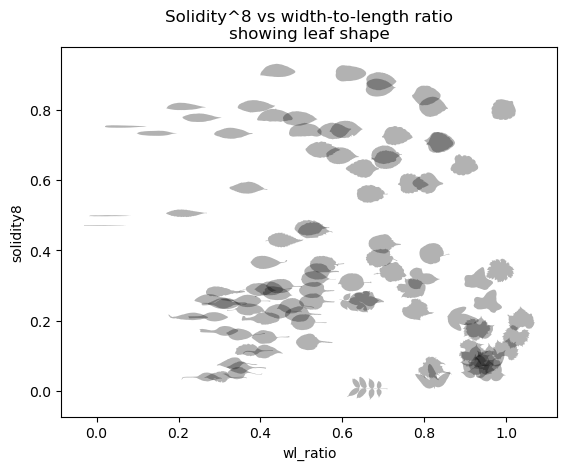

In [11]:
rand_num = 100 # set number of random leaves to visualize
scale = 0.03 # set scale of leaves
rand_state = 42 # set the random state

rand_plot_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random leaves

for i in range(len(rand_plot_df)): # for each of the randomly selected leaves
    
    curr_file = rand_plot_df["file"].iloc[i] # get current file
    curr_lf = np.load(curr_file)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
    
    curr_lfx = pca_scores[:,0]*scale+rand_plot_df["wl_ratio"].iloc[i]
    curr_lfy = pca_scores[:,1]*scale+rand_plot_df["solidity8"].iloc[i]
    
    plt.fill(curr_lfx, curr_lfy, lw=0, c="k", alpha=0.3)
    plt.xlabel("wl_ratio")
    plt.ylabel("solidity8")
    plt.title("Solidity^8 vs width-to-length ratio\nshowing leaf shape")

# Calculate ECTs for each leaf

In [12]:
num_dir=32 # set number of directional axes
num_thresh=48 # set number of thresholds each axis
rad = 0.5 # set the radius

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_arr = np.zeros((len(rand_df),num_dir,num_thresh))

for i in range(len(rand_df)): # for each leaf
    if i%100==0: # print if divisible by 100
        print(i)
    shape = np.load(rand_df["file"].iloc[i]) # get the current shape
    ect_arr[i,:,:] = get_ect(normal_sh=normalize(shape), # normalize the shape
           dir_num=num_dir, # calculate the ECT
           thresh_num=num_thresh,
           global_bound_radius=rad)

0
100
200
300
400
500
600


# Plot leaves next to ECTs

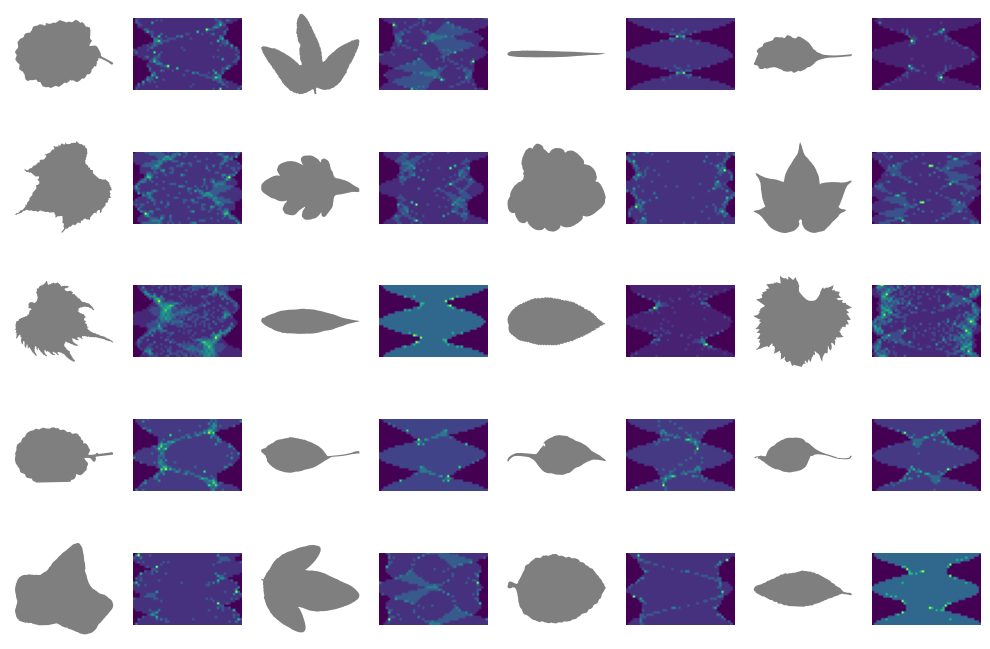

In [13]:
rand_num = 20 # set number of random leaves to visualize
rand_state = 42 # set the random state

rand_ect_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random leaves

counter = 1 # counter for plt.subplot
plt.figure(figsize=(10,7))

for i in rand_ect_df.index: # for each of the randomly chosen indices
    
    plt.subplot(5,8,counter)
    curr_file = rand_ect_df["file"][i] # get current file
    curr_lf = np.load(curr_file)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
    plt.fill(pca_scores[:,0], pca_scores[:,1], lw=0, c="k", alpha=0.5)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    
    counter+=1
    
    plt.subplot(5,8,counter)
    plt.imshow(ect_arr[i])
    plt.axis("off")
    plt.gca().set_aspect("equal")
    
    counter+=1
    
plt.tight_layout()
    
    
    
    

# Create distance matrix of ECTs

In [14]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 100
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600


# Perform MDS

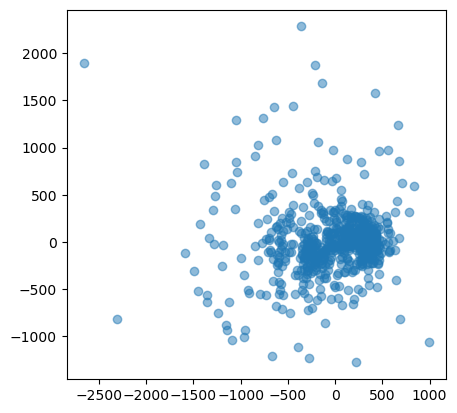

In [15]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


# Plot MDS with aspect ratio and solidity

In [16]:
# put MDS scores in rand_df for plotting

rand_df["MDS1"] = MDS_scores[:,0]
rand_df["MDS2"] = MDS_scores[:,1]

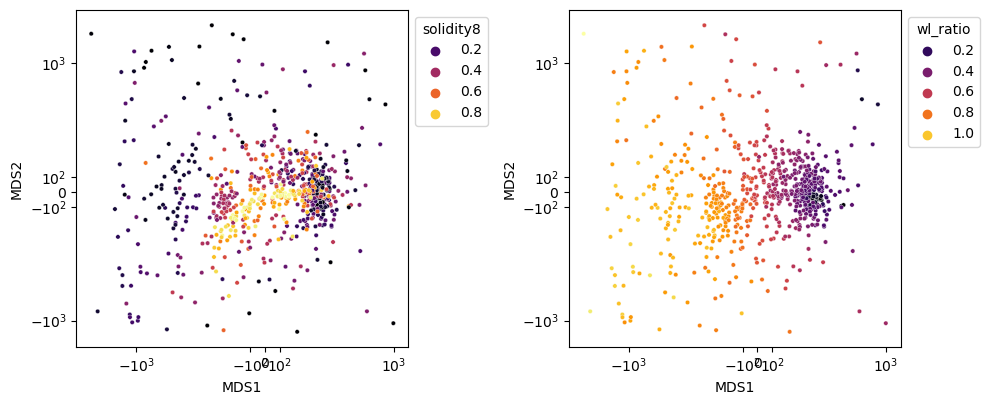

In [17]:
lt = 800

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="solidity8", palette="inferno")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.subplot(1,2,2)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="wl_ratio", palette="inferno")
plt.gca().set_aspect("equal")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.tight_layout()

Text(0.5, 1.0, 'MDS of ECT\nby group')

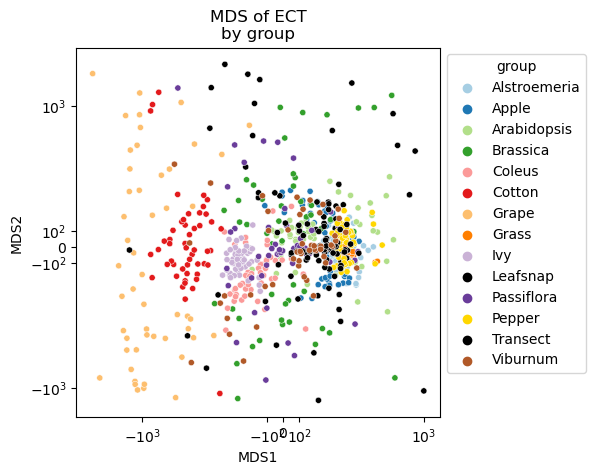

In [18]:
ax = sns.scatterplot(data=rand_df,
                x="MDS1",
                y="MDS2",
                s=20,
                hue="group", 
                palette=sns.color_palette(palette, 14))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("MDS of ECT\nby group")

Plot MDS plot with random leaf outlines

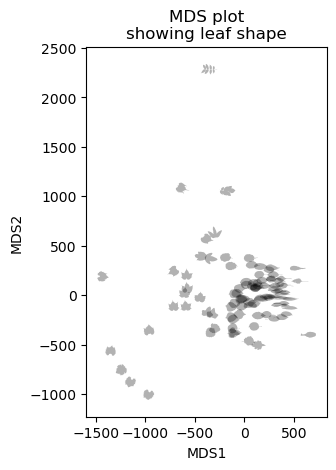

In [19]:
rand_num = 100 # set number of random leaves to visualize
scale = 50 # set scale of leaves
rand_state = 42 # set the random state

rand_plot_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random leaves

for i in range(len(rand_plot_df)): # for each of the randomly selected leaves
    
    curr_file = rand_plot_df["file"].iloc[i] # get current file
    curr_lf = np.load(curr_file)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
    
    curr_lfx = pca_scores[:,0]*scale+rand_plot_df["MDS1"].iloc[i]
    curr_lfy = pca_scores[:,1]*scale+rand_plot_df["MDS2"].iloc[i]
    
    plt.fill(curr_lfx, curr_lfy, lw=0, c="k", alpha=0.3)
    plt.gca().set_aspect("equal")
    plt.xlabel("MDS1")
    plt.ylabel("MDS2")
    plt.title("MDS plot\nshowing leaf shape")

__________

_______

____________

# From the [tutorial](https://github.com/MunchLab/ECT-Leaf-CNN/blob/main/leaf-example-tutorial/Tutorial-ECT_for_example_dataset.ipynb) on leaf shape classification by Sarah McGuire

# Classification by group types

## Create the following folder structure:

Within the pwd, a folder for the ect analysis and sub-folders for outline inputs and ect outputs.

```
+--group_ect_analysis
|    +--outline_input
|    +--ect_output
```

## Additionally, add `dataloaders.py`, `models.py`, and `utils.py` scripts from the github [repository](https://github.com/MunchLab/ECT-Leaf-CNN/tree/main/leaf-example-tutorial)

## Within the `dataloaders.py` file, change the `image_path` in the `create_datasets()` function:
- from `'/example_data/ect_output/'`
- to `'/group_ect_analysis/ect_output/'`

In [20]:
from ect import ECT, EmbeddedGraph

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

First, we need to save the ECT images we will be classifying as `.npy` files with sub-folders for each class.

We do not want `Leafsnap` or `Transect` leaves for this classification.

In [21]:
mypath_output = 'group_ect_analysis/outline_input/'

for i in range(len(rand_df)): # for each leaf

    curr_file = rand_df["file"].iloc[i] # get current file
    curr_group = rand_df["group"].iloc[i] # get current group
    
    if (curr_group=="Leafsnap") | (curr_group=="Transect"):
        continue # continue if a Leafsnap or Transect leaf
    
    curr_lf = np.load(curr_file) # load current leaf

    output_filedir = mypath_output+curr_group+"/X"+str(i)+".npy" # create output path
    Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True) # make directory
    np.save(output_filedir, curr_lf) # save output

# Create and save ECT outputs

In [23]:
mypath = 'group_ect_analysis/outline_input/'
mypath_output = 'group_ect_analysis/ect_output/'


# loop through file system
classes=[]
class_count = 0
for path, subdirs, files in os.walk(mypath):
    classes.extend(subdirs)
    files = [f for f in files if not f[0] == '.']
    subdirs[:] = [d for d in subdirs if (d[0] != '.')]
    print('Computing ECT of files in ', path, '...')
    print("There are ",len(files), ' samples to load in this directory.')
    
    for name in files:
        input_filedir = os.path.join(path, name)
        leaf = np.load(input_filedir)
        
        # Define a graph object for the leaf
        G = EmbeddedGraph()

        # Use coordinates of the leaf outline points to add vertices (and embedding coordinates) to the graph object
        valuesX = leaf[:,0]
        valuesY = leaf[:,1]
        for i in range(np.shape(leaf)[0]):
            G.add_node(i,valuesX[i],valuesY[i])

        # Add edges to the graph according to the outline order
        for i in range(np.shape(leaf)[0]-1):
            G.add_edge(i, i+1)
        G.add_edge(0,np.shape(leaf)[0]-1)
        
        # initialize the ECT object using 32 directions and 48 thresholds
        myect = ECT(num_dirs = 32, num_thresh=48)

        # Set the bounding radius to be the global dataset bounding radius
        # TO DO: compute the dataset global radius within ect package
        #global_bound_radius = 2.9092515639765497
        #myect.set_bounding_radius(global_bound_radius)

        myect.calculateECT(G)

        # The saved ECT matrix
        M = myect.get_ECT()


        # save the ECT matrix as a numpy file
        output_filedir = os.path.join(mypath_output+ input_filedir[len(mypath):])
        Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
        np.save(output_filedir, M)
        
        
    print('Saving the ECT of directory in ', path, '...')

Computing ECT of files in  group_ect_analysis/outline_input/ ...
There are  0  samples to load in this directory.
Saving the ECT of directory in  group_ect_analysis/outline_input/ ...
Computing ECT of files in  group_ect_analysis/outline_input/Apple ...
There are  50  samples to load in this directory.
Saving the ECT of directory in  group_ect_analysis/outline_input/Apple ...
Computing ECT of files in  group_ect_analysis/outline_input/Passiflora ...
There are  50  samples to load in this directory.
Saving the ECT of directory in  group_ect_analysis/outline_input/Passiflora ...
Computing ECT of files in  group_ect_analysis/outline_input/Ivy ...
There are  50  samples to load in this directory.
Saving the ECT of directory in  group_ect_analysis/outline_input/Ivy ...
Computing ECT of files in  group_ect_analysis/outline_input/Arabidopsis ...
There are  50  samples to load in this directory.
Saving the ECT of directory in  group_ect_analysis/outline_input/Arabidopsis ...
Computing ECT of f

# Train a CNN model on the ECT images

In [24]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [25]:
from models import CNN

Remember, within the `dataloaders.py` file, change the `image_path` in the `create_datasets()` function:
- from `'/example_data/ect_output/'`
- to `'/group_ect_analysis/ect_output/'`

In [26]:
from dataloaders import create_datasets, create_data_loaders
from utils import save_model, save_plots, save_cf, SaveBestModel

In [27]:
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float

In [28]:
# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



### Load in the dataset and split into training and test datasets

In [29]:
train_dataset, test_dataset = create_datasets()

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)

/Users/chitwoo9/Desktop/ECT/leaves/group_ect_analysis/ect_output/
['Apple', 'Passiflora', 'Ivy', 'Arabidopsis', 'Grass', 'Alstroemeria', 'Cotton', 'Viburnum', 'Grape', 'Brassica', 'Pepper', 'Coleus']
num_classes= 12
ECT data; using only normalize, rotation transforms on training data


In [30]:
trainimages, trainlabels = next(iter(train_loader))
print(f'The tensor shape of each batch in the training dataset is \n[batch_size, num_channels, num_directions, num_thresholds]: {trainimages.shape}')

The tensor shape of each batch in the training dataset is 
[batch_size, num_channels, num_directions, num_thresholds]: torch.Size([4, 1, 32, 48])


training images


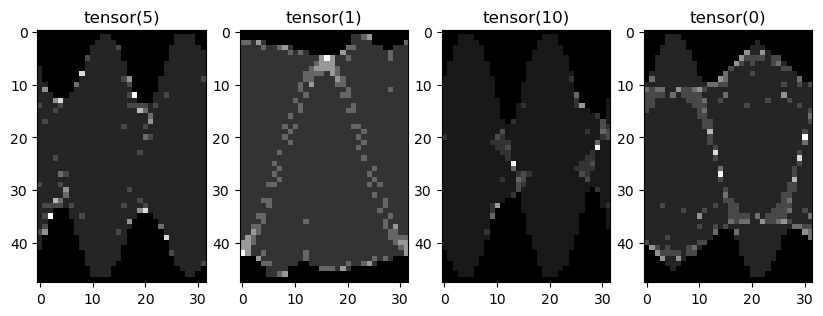

In [31]:
plt.style.use('default')
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print('training images')
for i in range(4):
    ax = axes[i]
    ax.imshow(trainimages[i,0,:,:].T, cmap='gray')
    ax.set_title(trainlabels[i])
plt.show()

In [32]:
def train(model, train_loader, optimizer, lossfcn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

In [33]:
# function for validation
def validate(model, valid_loader, lossfcn):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

In [34]:
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1]).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1920, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=12, bias=True)
)


In [35]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

1,981,324 total parameters.
1,981,324 training parameters.



In [36]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# loss function
lossfcn = nn.CrossEntropyLoss()
# initialize SaveBestModel class
save_best_model = SaveBestModel()

In [37]:
train_loss, valid_loss = [],[]
train_acc, valid_acc = [],[]

# begin training
for epoch in range(1,NUM_EPOCHS+1):
    print(f"[INFO]: Epoch {epoch} of {NUM_EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    # save the best model up to current epoch, if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, lossfcn
    )
    print('-'*50)
    

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 2.434, training acc: 14.583
Validation loss: 2.296, validation acc: 12.500

Best validation loss: 2.2957173148790995

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 2.143, training acc: 21.875
Validation loss: 2.073, validation acc: 28.333

Best validation loss: 2.0733235319455465

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.982, training acc: 31.458
Validation loss: 2.018, validation acc: 24.167

Best validation loss: 2.018292260169983

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.782, training acc: 38.750
Validation loss: 1.902, validation acc: 33.333

Best validation loss: 1.9023667395114898

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.666, training acc: 42.292
Validation loss: 1.776, validation acc: 39.167

Best validation loss: 1.7764477451642355

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.570, training acc: 45.625
Validation loss: 1.646, validation acc: 43.333

Best validation loss: 1.6462608456611634

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.451, training acc: 48.125
Validation loss: 1.529, validation acc: 46.667

Best validation loss: 1.5287379304567972

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.405, training acc: 52.083
Validation loss: 1.531, validation acc: 43.333
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.331, training acc: 52.292
Validation loss: 1.550, validation acc: 54.167
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.348, training acc: 53.333
Validation loss: 1.458, validation acc: 53.333

Best validation loss: 1.4579919874668121

Saving best model for epoch: 10

--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.283, training acc: 54.167
Validation loss: 1.385, validation acc: 49.167

Best validation loss: 1.3847646077473958

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.250, training acc: 56.875
Validation loss: 1.407, validation acc: 52.500
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.229, training acc: 58.542
Validation loss: 1.468, validation acc: 48.333
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.204, training acc: 58.958
Validation loss: 1.563, validation acc: 49.167
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.138, training acc: 60.000
Validation loss: 1.422, validation acc: 55.833
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.174, training acc: 58.333
Validation loss: 1.484, validation acc: 48.333
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.155, training acc: 58.333
Validation loss: 1.349, validation acc: 49.167

Best validation loss: 1.3490346511205038

Saving best model for epoch: 17

--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.096, training acc: 60.208
Validation loss: 1.348, validation acc: 55.000

Best validation loss: 1.3476346582174301

Saving best model for epoch: 18

--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.094, training acc: 61.875
Validation loss: 1.364, validation acc: 54.167
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.162, training acc: 59.375
Validation loss: 1.423, validation acc: 53.333
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.089, training acc: 61.458
Validation loss: 1.336, validation acc: 51.667

Best validation loss: 1.335649593671163

Saving best model for epoch: 21

--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.003, training acc: 62.917
Validation loss: 1.374, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.067, training acc: 60.000
Validation loss: 1.499, validation acc: 48.333
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.112, training acc: 61.042
Validation loss: 1.330, validation acc: 52.500

Best validation loss: 1.3304442892471948

Saving best model for epoch: 24

--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.987, training acc: 66.042
Validation loss: 1.449, validation acc: 51.667
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.944, training acc: 68.750
Validation loss: 1.547, validation acc: 48.333
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.971, training acc: 66.250
Validation loss: 1.316, validation acc: 60.833

Best validation loss: 1.3161570300658545

Saving best model for epoch: 27

--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.992, training acc: 65.625
Validation loss: 1.266, validation acc: 57.500

Best validation loss: 1.2658978303273518

Saving best model for epoch: 28

--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.984, training acc: 64.167
Validation loss: 1.414, validation acc: 56.667
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.937, training acc: 67.917
Validation loss: 1.357, validation acc: 55.833
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.971, training acc: 67.500
Validation loss: 1.327, validation acc: 57.500
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 1.001, training acc: 65.000
Validation loss: 1.344, validation acc: 54.167
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.984, training acc: 67.083
Validation loss: 1.363, validation acc: 57.500
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.986, training acc: 66.042
Validation loss: 1.398, validation acc: 58.333
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.933, training acc: 65.208
Validation loss: 1.323, validation acc: 53.333
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.880, training acc: 68.333
Validation loss: 1.474, validation acc: 52.500
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.909, training acc: 67.917
Validation loss: 1.459, validation acc: 57.500
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.870, training acc: 66.875
Validation loss: 1.387, validation acc: 56.667
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.895, training acc: 69.583
Validation loss: 1.539, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.917, training acc: 66.667
Validation loss: 1.344, validation acc: 54.167
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.850, training acc: 71.250
Validation loss: 1.404, validation acc: 60.833
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.941, training acc: 65.208
Validation loss: 1.397, validation acc: 53.333
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.816, training acc: 71.875
Validation loss: 1.416, validation acc: 56.667
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.897, training acc: 68.125
Validation loss: 1.295, validation acc: 59.167
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.813, training acc: 73.125
Validation loss: 1.302, validation acc: 55.000
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.830, training acc: 70.208
Validation loss: 1.445, validation acc: 60.000
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.819, training acc: 72.292
Validation loss: 1.388, validation acc: 60.000
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.806, training acc: 71.667
Validation loss: 1.452, validation acc: 56.667
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.834, training acc: 70.833
Validation loss: 1.315, validation acc: 56.667
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/120 [00:00<?, ?it/s]

Validation


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.773, training acc: 70.625
Validation loss: 1.459, validation acc: 55.000
--------------------------------------------------


Saving final model...


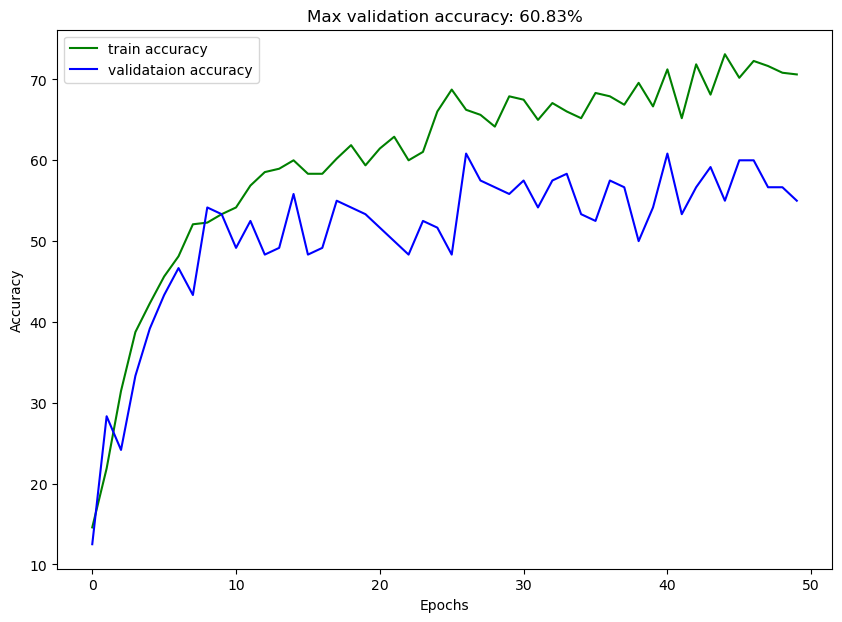

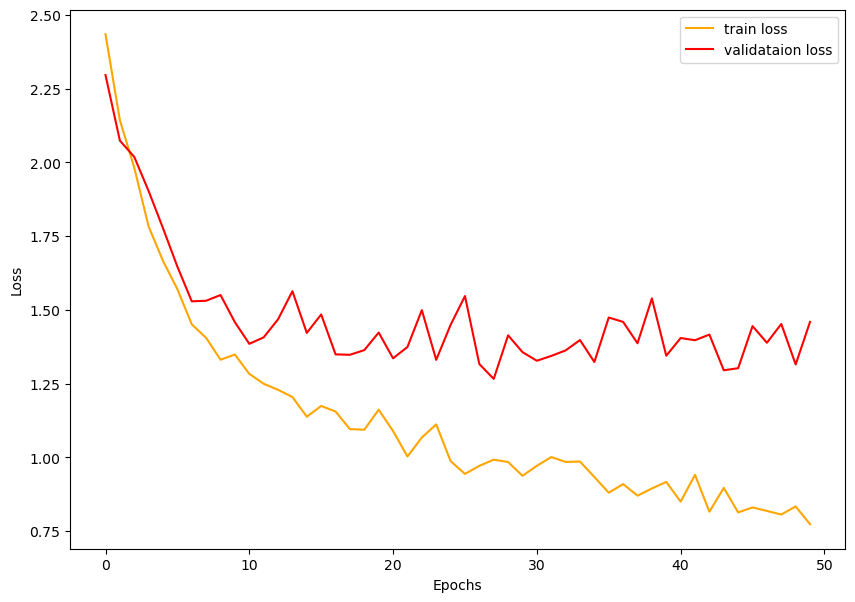

In [38]:
save_model(NUM_EPOCHS, model, optimizer, lossfcn)
save_plots(train_acc, valid_acc, train_loss, valid_loss)

Using validation to compute confusion matrix


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_45250/207180029.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pt

  0%|          | 0/30 [00:00<?, ?it/s]

classes: ['Apple', 'Passiflora', 'Ivy', 'Arabidopsis', 'Grass', 'Alstroemeria', 'Cotton', 'Viburnum', 'Grape', 'Brassica', 'Pepper', 'Coleus']
Test Result:
Accuracy Score: 57.50%
_______________________________________________
CLASSIFICATION REPORT:
                  0          1         2          3         4         5  \
precision  0.300000   0.400000  0.777778   0.500000  1.000000  0.384615   
recall     0.333333   0.153846  0.875000   0.636364  0.714286  0.714286   
f1-score   0.315789   0.222222  0.823529   0.560000  0.833333  0.500000   
support    9.000000  13.000000  8.000000  11.000000  7.000000  7.000000   

                   6          7          8         9         10         11  \
precision   0.750000   0.500000   1.000000  0.250000   0.500000   0.652174   
recall      0.600000   0.250000   0.818182  0.400000   0.416667   1.000000   
f1-score    0.666667   0.333333   0.900000  0.307692   0.454545   0.789474   
support    10.000000  12.000000  11.000000  5.000000  12.00000

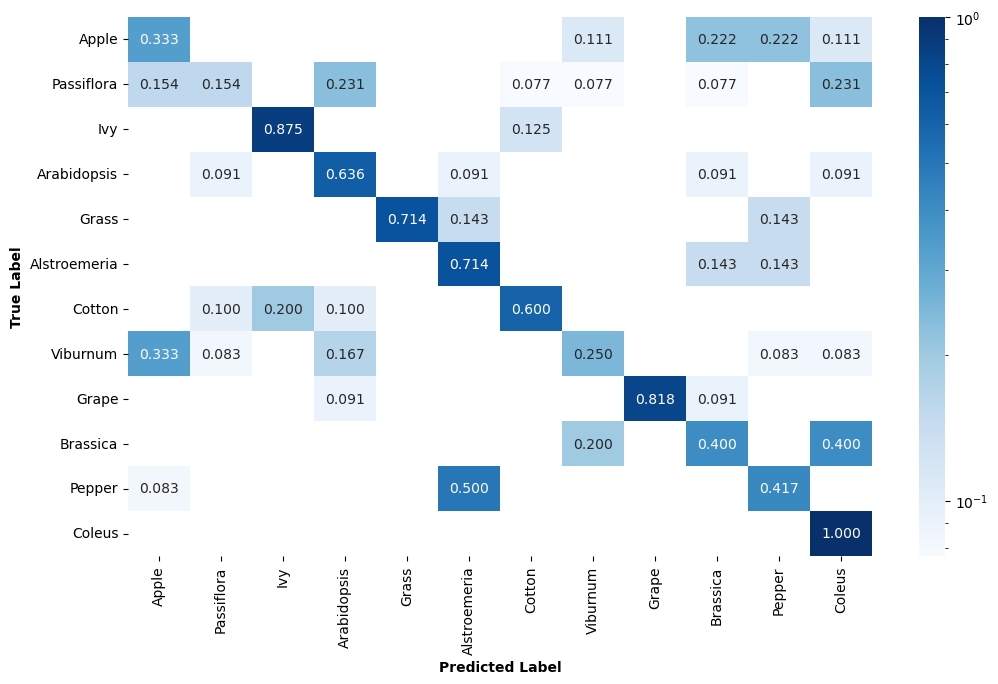

In [39]:
# model, valid_loader, lossfcn
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1])

state_dict = torch.load('outputs/best_model.pth')['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
print('Using validation to compute confusion matrix')
valid_running_pred = []
valid_running_labels = []
counter = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)

        valid_running_pred.append(preds)
        valid_running_labels.append(labels)
    
# confusion matrix for the complete epoch
valid_running_pred = torch.cat(valid_running_pred)
valid_running_labels = torch.cat(valid_running_labels)
print('classes:',test_dataset.classes)
save_cf(valid_running_pred,valid_running_labels, test_dataset.classes)

____________

____________

____________

# Classification by plant family

The plant family information associated with the `Leafsnap` and `Transect` datasets can be found at the following [link](https://figshare.com/articles/dataset/LeafMorphospace/4985561/1?file=8392724). The specific file used here to retrieve plant family data is `./LeafMorphospace/Analysis/2.PHYLO_analysis_Figure4/PHYL_sha_desc.txt`.

In [9]:
# read in the plant family metadata

family_df = pd.read_csv("./PHYL_sha_desc.txt", sep='\t')

family_df.head()

,filename,dataset,dataset2,species,genus,family,order,order_tree,site,region,...,PC174,PC175,PC176,PC177,PC178,PC179,circ,ar,round,solid
0,abies_concolor_ny1157_01_4,Leafsnap,Leafsnap,concolor,abies,Pinaceae,Pinales,2,NaN,NaN,...,0.152912,-0.566131,-0.775891,-0.549495,-0.644656,1.249833,0.188,12.225,0.082,0.778
1,abies_concolor_ny1157_02_4,Leafsnap,Leafsnap,concolor,abies,Pinaceae,Pinales,2,NaN,NaN,...,-0.212867,0.451178,0.949687,-0.309438,-0.848516,-0.894984,0.190,12.235,0.082,0.829
2,abies_concolor_ny1157_03_4,Leafsnap,Leafsnap,concolor,abies,Pinaceae,Pinales,2,NaN,NaN,...,0.225298,0.235804,-0.382426,-0.227588,-0.807487,-0.549086,0.194,12.120,0.083,0.765
3,abies_concolor_ny1157_04_4,Leafsnap,Leafsnap,concolor,abies,Pinaceae,Pinales,2,NaN,NaN,...,0.543623,0.527144,-1.979176,1.872710,-1.166254,2.643690,0.249,9.691,0.103,0.828
4,abies_concolor_ny1157_05_4,Leafsnap,Leafsnap,concolor,abies,Pinaceae,Pinales,2,NaN,NaN,...,-0.428718,-0.750612,-1.535337,0.235716,-0.541335,0.894738,0.204,11.853,0.084,0.790


In [10]:
# create a new dataframe with just Transect and Leafsnap data

phylo_df = lf_df[(lf_df["group"]=="Transect")|(lf_df["group"]=="Leafsnap")]
print("Length of phylo_df is", len(phylo_df))

Length of phylo_df is 10373


Find the plant family for each file

In [11]:
plant_fams = [] # to store plant families

for i in range(len(phylo_df)): # for each of the Transect or Leafsnap files
    
    if i%1000==0: # for every 1000 iterations print i
        print(i)

    curr_file = phylo_df["file"].iloc[i] # get the current file name
    match = "no" # set match to "no" intially

    for j in range(len(family_df)): # for each of the metadata entries

        if family_df["filename"].iloc[j] in curr_file: # see if there is a match with the current file
            plant_fams.append(family_df["ordered_family"].iloc[j]) # if so, save the plant family
            match = "yes" # set match to "yes"
            break # break the loop if a match

        else:
            continue # if not a match, continue

    if match=="no": # if no match found, add "NaN"
        plant_fams.append("NaN")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [12]:
pd.options.mode.chained_assignment = None  # default='warn'

# add the list of plant families to the phylo_df
# suppress the warning for now
phylo_df["family"] = np.array(plant_fams)

In [13]:
# remove cases where a plant family was not identified
phylo_df = phylo_df[phylo_df["family"]!="NaN"]

print("After removing NaNs the len of phylo_df is", len(phylo_df))

After removing NaNs the len of phylo_df is 9988


In [14]:
print("There are", len(phylo_df["family"].unique()), "families")

There are 141 families


## Create the following folder structure:

Within the pwd, a folder for the ect analysis and sub-folders for outline inputs and ect outputs.

```
+--phylo_ect_analysis
|    +--outline_input
|    +--ect_output
```

## Additionally, add `dataloaders.py`, `models.py`, and `utils.py` scripts from the github [repository](https://github.com/MunchLab/ECT-Leaf-CNN/tree/main/leaf-example-tutorial)

## Within the `dataloaders.py` file, change the `image_path` in the `create_datasets()` function:
- from `'/example_data/ect_output/'`
- to `'/phylo_ect_analysis/ect_output/'`

In [15]:
from ect import ECT, EmbeddedGraph

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

First, we need to save the ECT images we will be classifying as `.npy` files with sub-folders for each class.

In [100]:
mypath_output = 'phylo_ect_analysis/outline_input/'

for i in range(len(phylo_df)): # for each leaf
    
    if i%1000==0: # for every 1000 iterations print i
        print(i)

    curr_file = phylo_df["file"].iloc[i] # get current file
    curr_family = phylo_df["family"].iloc[i] # get current family
    curr_lf = np.load(curr_file) # load current leaf

    output_filedir = mypath_output+curr_family+"/X"+str(i)+".npy" # create output path
    Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True) # make directory
    np.save(output_filedir, curr_lf) # save output

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


# Create and save ECT outputs

(about 45 minutes to run locally)
(reminder: add a print(i) statement somewhere separate from directory structure)

In [101]:
mypath = 'phylo_ect_analysis/outline_input/'
mypath_output = 'phylo_ect_analysis/ect_output/'


# loop through file system
classes=[]
class_count = 0
for path, subdirs, files in os.walk(mypath):
    classes.extend(subdirs)
    files = [f for f in files if not f[0] == '.']
    subdirs[:] = [d for d in subdirs if (d[0] != '.')]
    print('Computing ECT of files in ', path, '...')
    print("There are ",len(files), ' samples to load in this directory.')
    
    for name in files:
        input_filedir = os.path.join(path, name)
        leaf = np.load(input_filedir)
        
        # Define a graph object for the leaf
        G = EmbeddedGraph()

        # Use coordinates of the leaf outline points to add vertices (and embedding coordinates) to the graph object
        valuesX = leaf[:,0]
        valuesY = leaf[:,1]
        for i in range(np.shape(leaf)[0]):
            G.add_node(i,valuesX[i],valuesY[i])

        # Add edges to the graph according to the outline order
        for i in range(np.shape(leaf)[0]-1):
            G.add_edge(i, i+1)
        G.add_edge(0,np.shape(leaf)[0]-1)
        
        # initialize the ECT object using 32 directions and 48 thresholds
        myect = ECT(num_dirs = 32, num_thresh=48)

        # Set the bounding radius to be the global dataset bounding radius
        # TO DO: compute the dataset global radius within ect package
        #global_bound_radius = 2.9092515639765497
        #myect.set_bounding_radius(global_bound_radius)

        myect.calculateECT(G)

        # The saved ECT matrix
        M = myect.get_ECT()


        # save the ECT matrix as a numpy file
        output_filedir = os.path.join(mypath_output+ input_filedir[len(mypath):])
        Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
        np.save(output_filedir, M)
        
        
    print('Saving the ECT of directory in ', path, '...')

Computing ECT of files in  phylo_ect_analysis/outline_input/ ...
There are  0  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/ ...
Computing ECT of files in  phylo_ect_analysis/outline_input/25_Onagraceae ...
There are  2  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/25_Onagraceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/20_Picrodendraceae ...
There are  1  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/20_Picrodendraceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/09_Zingiberaceae ...
There are  5  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/09_Zingiberaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/25_Vochysiaceae ...
There are  1  samples to load in this directory.
Saving the ECT of directory in  phylo_ect

Saving the ECT of directory in  phylo_ect_analysis/outline_input/22_Urticaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/05_Myristicaceae ...
There are  7  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/05_Myristicaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/34_Actinidiaceae ...
There are  19  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/34_Actinidiaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/20_Calophyllaceae ...
There are  9  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/20_Calophyllaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/20_Hypericaceae ...
There are  3  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/20_Hypericaceae ...
Computing ECT of files in  phylo_ect_analysis/outlin

Saving the ECT of directory in  phylo_ect_analysis/outline_input/01_Ginkgoaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/41_Goodeniaceae ...
There are  16  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/41_Goodeniaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/39_Bignoniaceae ...
There are  91  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/39_Bignoniaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/06_Atherospermataceae ...
There are  3  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/06_Atherospermataceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/34_Primulaceae ...
There are  86  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/34_Primulaceae ...
Computing ECT of files in  phylo_ect_analysis/o

Saving the ECT of directory in  phylo_ect_analysis/outline_input/05_Annonaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/26_Staphyleaceae ...
There are  37  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/26_Staphyleaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/20_Phyllanthaceae ...
There are  44  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/20_Phyllanthaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/34_Ebenaceae ...
There are  90  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/34_Ebenaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/39_Lamiaceae ...
There are  60  samples to load in this directory.
Saving the ECT of directory in  phylo_ect_analysis/outline_input/39_Lamiaceae ...
Computing ECT of files in  phylo_ect_analysis/outline_input/42_

# Train a CNN model on the ECT images

In [16]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [17]:
from models import CNN

Remember, within the `dataloaders.py` file, change the `image_path` in the `create_datasets()` function:
- from `'/example_data/ect_output/'`
- to `'/group_ect_analysis/ect_output/'`

In [18]:
from dataloaders import create_datasets, create_data_loaders
from utils import save_model, save_plots, save_cf, SaveBestModel

In [19]:
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float

In [20]:
# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



### Load in the dataset and split into training and test datasets

In [21]:
train_dataset, test_dataset = create_datasets()

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)

/Users/chitwoo9/Desktop/ECT/leaves/phylo_ect_analysis/ect_output/
['25_Onagraceae', '20_Picrodendraceae', '09_Zingiberaceae', '25_Vochysiaceae', '23_Tetramelaceae', '10_Lardizabalaceae', '28_Simaroubaceae', '19_Brunelliaceae', '12_Trochodendraceae', '39_Scrophulariaceae', '20_Lacistemataceae', '28_Sapindaceae', '39_Acanthaceae', '20_Malpighiaceae', '31_Schoepfiaceae', '04_Chloranthaceae', '06_Lauraceae', '28_Meliaceae', '32_Nyctaginaceae', '22_Rhamnaceae', '40_Aquifoliaceae', '15_Grossulariaceae', '34_Sapotaceae', '10_Ranunculaceae', '37_Solanaceae', '05_Magnoliaceae', '20_Clusiaceae', '20_Balanopaceae', '20_Passifloraceae', '22_Rosaceae', '34_Fouquieriaceae', '29_Malvaceae', '39_Oleaceae', '02_Pinaceae', '20_Chrysobalanaceae', '31_Olacaceae', '28_Rutaceae', '22_Urticaceae', '05_Myristicaceae', '34_Actinidiaceae', '20_Calophyllaceae', '20_Hypericaceae', '22_Elaeagnaceae', '34_Cyrillaceae', '34_Ericaceae', '34_Styracaceae', '40_Cardiopteridaceae', '34_Marcgraviaceae', '21_Polygalaceae',

In [22]:
trainimages, trainlabels = next(iter(train_loader))
print(f'The tensor shape of each batch in the training dataset is \n[batch_size, num_channels, num_directions, num_thresholds]: {trainimages.shape}')

The tensor shape of each batch in the training dataset is 
[batch_size, num_channels, num_directions, num_thresholds]: torch.Size([4, 1, 32, 48])


training images


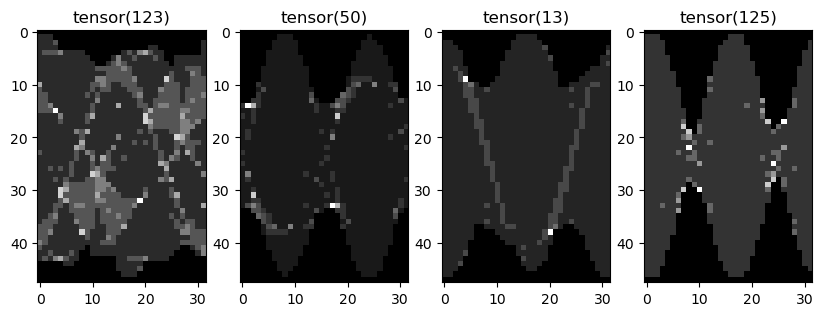

In [23]:
plt.style.use('default')
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print('training images')
for i in range(4):
    ax = axes[i]
    ax.imshow(trainimages[i,0,:,:].T, cmap='gray')
    ax.set_title(trainlabels[i])
plt.show()

In [24]:
def train(model, train_loader, optimizer, lossfcn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

In [25]:
# function for validation
def validate(model, valid_loader, lossfcn):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

In [26]:
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1]).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1920, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=141, bias=True)
)


In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

2,113,549 total parameters.
2,113,549 training parameters.



In [28]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# loss function
lossfcn = nn.CrossEntropyLoss()
# initialize SaveBestModel class
save_best_model = SaveBestModel()

In [29]:
train_loss, valid_loss = [],[]
train_acc, valid_acc = [],[]

# begin training
for epoch in range(1,NUM_EPOCHS+1):
    print(f"[INFO]: Epoch {epoch} of {NUM_EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    # save the best model up to current epoch, if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, lossfcn
    )
    print('-'*50)
    

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.758, training acc: 13.091
Validation loss: 3.539, validation acc: 16.466

Best validation loss: 3.539210294008255

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.512, training acc: 16.446
Validation loss: 3.418, validation acc: 17.317

Best validation loss: 3.4183085753917695

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.419, training acc: 17.071
Validation loss: 3.317, validation acc: 16.817

Best validation loss: 3.3165590398311613

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.364, training acc: 18.173
Validation loss: 3.303, validation acc: 17.067

Best validation loss: 3.3032983095645903

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.322, training acc: 18.498
Validation loss: 3.263, validation acc: 18.318

Best validation loss: 3.2632212343215943

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.270, training acc: 19.524
Validation loss: 3.215, validation acc: 19.570

Best validation loss: 3.214657833337784

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.244, training acc: 20.363
Validation loss: 3.166, validation acc: 21.722

Best validation loss: 3.1663967473506927

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.205, training acc: 20.726
Validation loss: 3.176, validation acc: 20.771
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.186, training acc: 21.264
Validation loss: 3.100, validation acc: 23.173

Best validation loss: 3.099589908838272

Saving best model for epoch: 9

--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.163, training acc: 21.952
Validation loss: 3.176, validation acc: 19.219
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.139, training acc: 22.240
Validation loss: 3.111, validation acc: 23.223
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.123, training acc: 22.416
Validation loss: 3.105, validation acc: 21.021
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.122, training acc: 22.678
Validation loss: 3.094, validation acc: 22.422

Best validation loss: 3.0944716334342957

Saving best model for epoch: 13

--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.096, training acc: 23.204
Validation loss: 3.081, validation acc: 22.523

Best validation loss: 3.0813929908275606

Saving best model for epoch: 14

--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.090, training acc: 23.179
Validation loss: 3.078, validation acc: 25.626

Best validation loss: 3.0783707824945448

Saving best model for epoch: 15

--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.069, training acc: 23.404
Validation loss: 3.071, validation acc: 23.123

Best validation loss: 3.0705159885883333

Saving best model for epoch: 16

--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.078, training acc: 23.129
Validation loss: 3.036, validation acc: 25.325

Best validation loss: 3.036426396727562

Saving best model for epoch: 17

--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.057, training acc: 23.767
Validation loss: 3.061, validation acc: 23.273
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.055, training acc: 23.830
Validation loss: 3.040, validation acc: 24.625
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.037, training acc: 24.055
Validation loss: 3.022, validation acc: 24.725

Best validation loss: 3.022487454414368

Saving best model for epoch: 20

--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.042, training acc: 24.118
Validation loss: 3.001, validation acc: 24.424

Best validation loss: 3.001041196703911

Saving best model for epoch: 21

--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.031, training acc: 23.867
Validation loss: 2.974, validation acc: 26.927

Best validation loss: 2.973825125217438

Saving best model for epoch: 22

--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.011, training acc: 24.919
Validation loss: 2.969, validation acc: 24.975

Best validation loss: 2.969436255812645

Saving best model for epoch: 23

--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.013, training acc: 24.080
Validation loss: 2.973, validation acc: 25.425
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.993, training acc: 24.731
Validation loss: 2.984, validation acc: 24.725
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.003, training acc: 24.543
Validation loss: 2.964, validation acc: 26.126

Best validation loss: 2.9642555516958238

Saving best model for epoch: 26

--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.005, training acc: 24.618
Validation loss: 3.080, validation acc: 22.873
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 3.000, training acc: 24.768
Validation loss: 2.985, validation acc: 25.676
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.982, training acc: 25.557
Validation loss: 2.962, validation acc: 26.777

Best validation loss: 2.961943605899811

Saving best model for epoch: 29

--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.977, training acc: 25.845
Validation loss: 2.979, validation acc: 26.176
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.983, training acc: 25.544
Validation loss: 2.968, validation acc: 26.326
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.971, training acc: 25.394
Validation loss: 3.027, validation acc: 25.125
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.978, training acc: 25.469
Validation loss: 2.947, validation acc: 27.628

Best validation loss: 2.9467431602478027

Saving best model for epoch: 33

--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.965, training acc: 25.670
Validation loss: 2.941, validation acc: 26.376

Best validation loss: 2.940861431479454

Saving best model for epoch: 34

--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.960, training acc: 25.707
Validation loss: 2.963, validation acc: 26.226
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.968, training acc: 25.207
Validation loss: 2.953, validation acc: 26.977
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.956, training acc: 26.008
Validation loss: 2.932, validation acc: 27.027

Best validation loss: 2.9317834792137147

Saving best model for epoch: 37

--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.951, training acc: 25.544
Validation loss: 2.955, validation acc: 26.777
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.957, training acc: 26.083
Validation loss: 2.941, validation acc: 27.077
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.950, training acc: 26.395
Validation loss: 2.937, validation acc: 27.277
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.946, training acc: 26.320
Validation loss: 2.930, validation acc: 26.276

Best validation loss: 2.930005894958973

Saving best model for epoch: 41

--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.956, training acc: 25.757
Validation loss: 2.928, validation acc: 27.628

Best validation loss: 2.9281072390079497

Saving best model for epoch: 42

--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.945, training acc: 26.446
Validation loss: 2.932, validation acc: 27.227
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.939, training acc: 26.483
Validation loss: 2.929, validation acc: 25.826
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.940, training acc: 26.733
Validation loss: 2.937, validation acc: 27.828
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.940, training acc: 26.308
Validation loss: 2.907, validation acc: 28.478

Best validation loss: 2.9074718985557557

Saving best model for epoch: 46

--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.929, training acc: 26.408
Validation loss: 2.934, validation acc: 25.275
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.938, training acc: 26.258
Validation loss: 2.929, validation acc: 28.278
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.928, training acc: 26.658
Validation loss: 2.946, validation acc: 25.976
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/1998 [00:00<?, ?it/s]

Validation


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 2.929, training acc: 26.446
Validation loss: 2.937, validation acc: 27.427
--------------------------------------------------


Saving final model...


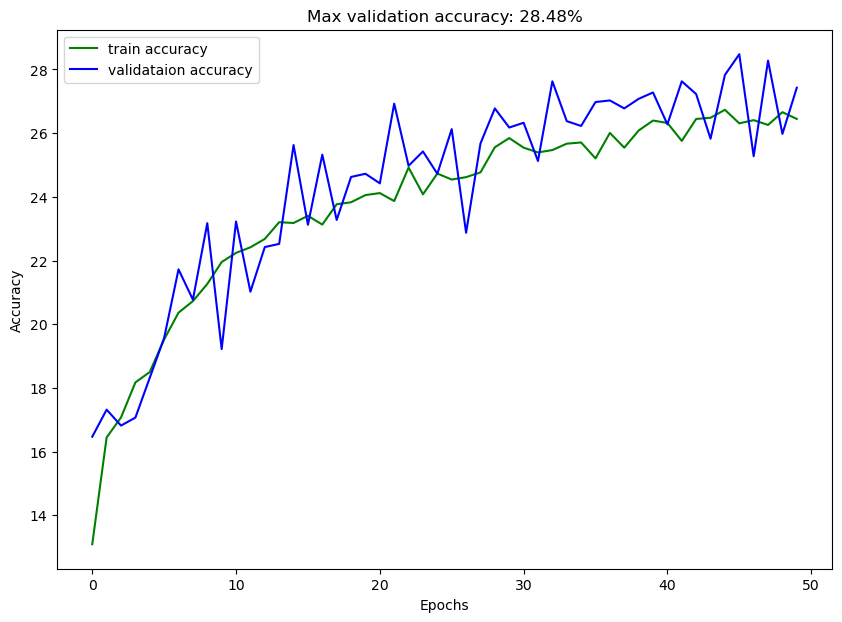

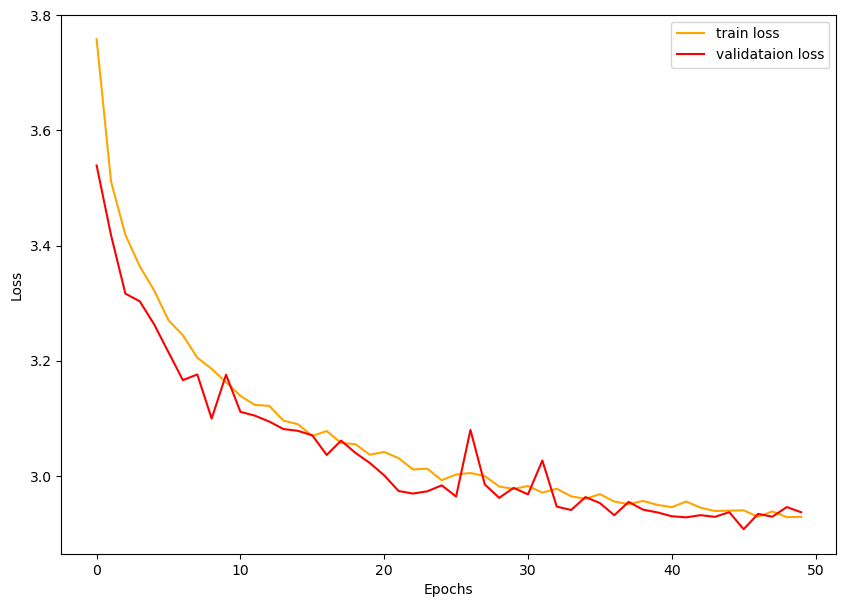

In [30]:
save_model(NUM_EPOCHS, model, optimizer, lossfcn)
save_plots(train_acc, valid_acc, train_loss, valid_loss)

Using validation to compute confusion matrix


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_51333/207180029.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pt

  0%|          | 0/500 [00:00<?, ?it/s]

classes: ['25_Onagraceae', '20_Picrodendraceae', '09_Zingiberaceae', '25_Vochysiaceae', '23_Tetramelaceae', '10_Lardizabalaceae', '28_Simaroubaceae', '19_Brunelliaceae', '12_Trochodendraceae', '39_Scrophulariaceae', '20_Lacistemataceae', '28_Sapindaceae', '39_Acanthaceae', '20_Malpighiaceae', '31_Schoepfiaceae', '04_Chloranthaceae', '06_Lauraceae', '28_Meliaceae', '32_Nyctaginaceae', '22_Rhamnaceae', '40_Aquifoliaceae', '15_Grossulariaceae', '34_Sapotaceae', '10_Ranunculaceae', '37_Solanaceae', '05_Magnoliaceae', '20_Clusiaceae', '20_Balanopaceae', '20_Passifloraceae', '22_Rosaceae', '34_Fouquieriaceae', '29_Malvaceae', '39_Oleaceae', '02_Pinaceae', '20_Chrysobalanaceae', '31_Olacaceae', '28_Rutaceae', '22_Urticaceae', '05_Myristicaceae', '34_Actinidiaceae', '20_Calophyllaceae', '20_Hypericaceae', '22_Elaeagnaceae', '34_Cyrillaceae', '34_Ericaceae', '34_Styracaceae', '40_Cardiopteridaceae', '34_Marcgraviaceae', '21_Polygalaceae', '16_Vitaceae', '43_Adoxaceae', '36_Loganiaceae', '38_Bor

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Result:
Accuracy Score: 27.68%
_______________________________________________
CLASSIFICATION REPORT:
             0    4    5     6    9          11   12   13    16    17  ...  \
precision  0.0  0.0  0.0   0.0  0.0    0.401361  0.0  0.0   0.0   0.0  ...   
recall     0.0  0.0  0.0   0.0  0.0    0.504274  0.0  0.0   0.0   0.0  ...   
f1-score   0.0  0.0  0.0   0.0  0.0    0.446970  0.0  0.0   0.0   0.0  ...   
support    1.0  1.0  2.0  13.0  1.0  117.000000  1.0  2.0  40.0  16.0  ...   

                  132        133  134  135  136  137  138  accuracy  \
precision    0.225316   0.200000  0.0  0.0  0.0  0.0  0.0  0.276777   
recall       0.483696   0.062500  0.0  0.0  0.0  0.0  0.0  0.276777   
f1-score     0.307427   0.095238  0.0  0.0  0.0  0.0  0.0  0.276777   
support    184.000000  16.000000  3.0  1.0  1.0  2.0  3.0  0.276777   

             macro avg  weighted avg  
precision     0.088678      0.228664  
recall        0.075893      0.276777  
f1-score      0.074087      0

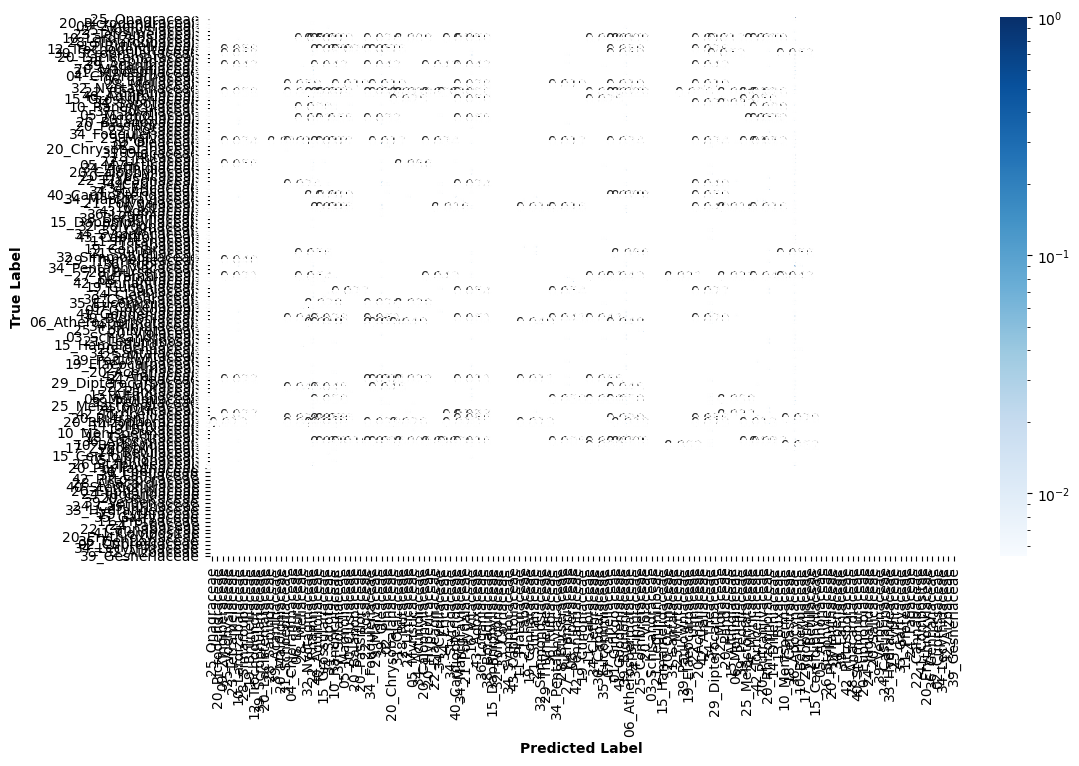

In [31]:
# model, valid_loader, lossfcn
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1])

state_dict = torch.load('outputs/best_model.pth')['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
print('Using validation to compute confusion matrix')
valid_running_pred = []
valid_running_labels = []
counter = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)

        valid_running_pred.append(preds)
        valid_running_labels.append(labels)
    
# confusion matrix for the complete epoch
valid_running_pred = torch.cat(valid_running_pred)
valid_running_labels = torch.cat(valid_running_labels)
print('classes:',test_dataset.classes)
save_cf(valid_running_pred,valid_running_labels, test_dataset.classes)

____________

____________

____________

In [296]:
def ect_diff_pca(ect1, ect2, dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    flip_ect1 = np.flip(ect1, axis=0) # flip ECT axes
    trans_ect1 = np.roll(ect1, int(dir_num/2), axis=0) # translate ECT axes
    ft_ect1 = np.roll(flip_ect1, int(dir_num/2), axis=0) # translate ECT axes

    diff_orig = np.sum(np.abs(ect2 - ect1)) # difference between ECT and original
    diff_flip = np.sum(np.abs(ect2 - flip_ect1)) # difference between ECT and flipped
    diff_trans = np.sum(np.abs(ect2 - trans_ect1)) # difference between ECT and translated
    diff_ft = np.sum(np.abs(ect2 - ft_ect1)) # difference between ECT and flipped translated

    return np.min([diff_orig,diff_flip,diff_trans,diff_ft])

In [297]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 100
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff_pca(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


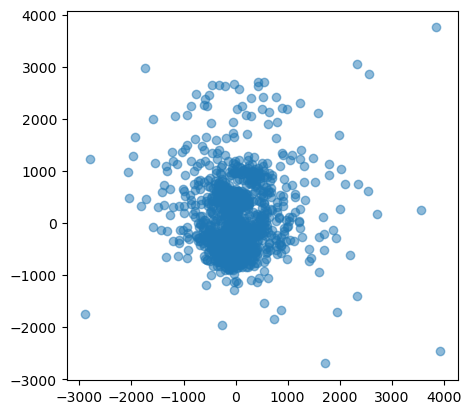

In [298]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


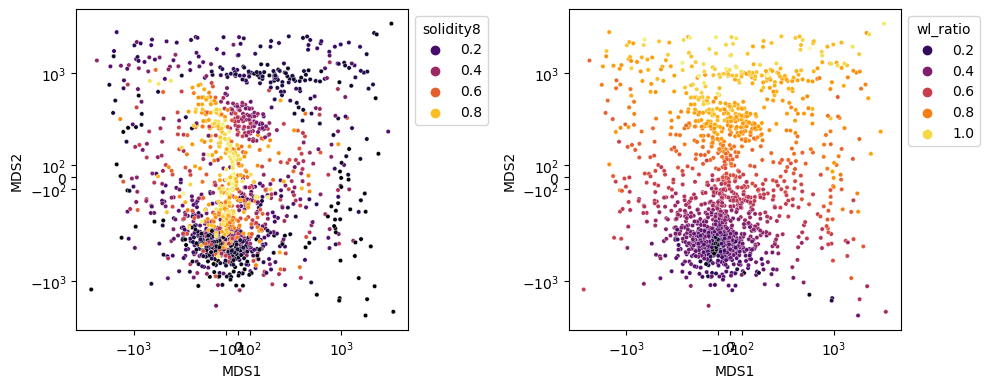

In [299]:
lt = 800

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="solidity8", palette="inferno")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.subplot(1,2,2)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="wl_ratio", palette="inferno")
plt.gca().set_aspect("equal")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.tight_layout()

Text(0.5, 1.0, 'MDS of ECT\nby group')

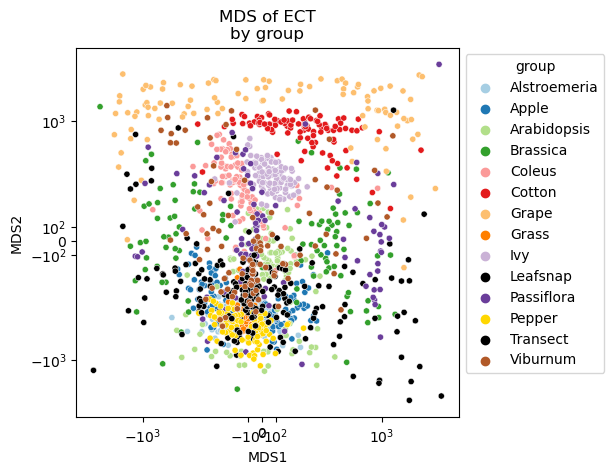

In [300]:
ax = sns.scatterplot(data=rand_df,
                x="MDS1",
                y="MDS2",
                s=20,
                hue="group", 
                palette=sns.color_palette(palette, 14))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("MDS of ECT\nby group")